In [46]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [47]:
class TwoLayerNet(object):
    """
    two-layer-perceptron.
    Input dimension : N
    Hidden layer dimension : H
    Output dimension : C

    input - linear layer - ReLU - linear layer - output
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        W1: first layer's weight; (D, H)
        b1: first layer's bias; (H,)
        W2: second layer's weight; (H, C)
        b2: second layer's bias; (C,)
        """
        
        self.params = {}
        self.params['W1'] = std * torch.randn(input_size, hidden_size)
        self.params['b1'] = torch.zeros(hidden_size)
        self.params['W2'] = std * torch.randn(hidden_size, output_size)
        self.params['b2'] = torch.zeros(output_size)
    

    def loss(self, X, y=None):
        """
        Neural network의 loss와 gradient를 직접 계산하자.

        Inputs:
        - X: Input data. shape (N, D). 각각의 X[i]가 하나의 training sample이며 총 N개의 sample이 input으로 주어짐.
        - y: Training label 벡터. y[i]는 X[i]에 대한 정수값의 label.
          y가 주어질 경우 loss와 gradient를 반환하며 y가 주어지지 않으면 output을 반환

        Returns:
        y가 주어지지 않으면, shape (N, C)인 score matrix 반환
        scores[i, c]는 input X[i]에 대한 class c의 score

        y가 주어지면 (loss, grads) tuple 반환
        loss: training batch에 대한 loss (scalar)
        grads: {parameter 이름: gradient} 형태의 dictionary
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.size()

        # Forward path
        hidden = X.mm(W1) + b1
        hidden_relu = hidden.clamp(min=0)
        scores = hidden_relu.mm(W2) + b2

        # 정답(target)이 주어지지 않은 경우 점수를 리턴하고 종료
        if y is None:
            return scores

        # Softmax loss function
        e = torch.exp(scores)
        softmax = e / torch.sum(e, dim=1, keepdim=True)
        ### 이부분 더 쉽게 바꿀 수 있지 않을까 ###
        N, C = softmax.size()
        y_tensor = torch.zeros(N, C)
        for i in range(0, N):
            y_tensor[i, y[i]] = 1
        nll = -1 * torch.log(softmax)
        loss = (nll.reshape(1, N*C)).mm(y_tensor.reshape(N*C, 1))

        # Backward path(Gradient calculation)
        grads = {} 
        ### 이부분 cs231n 코드에 dictionary 활용부분 봐야됨 ###
        softmax_grads = softmax.sub(y_tensor)
        grads['W2'] = (hidden_relu.t()).mm(softmax_grads)
        grads['b2'] = softmax_grads
        hidden_relu_grads = softmax_grads.mm(W2.t())
        hidden_grads = hidden_relu_grads.clone()
        grads['W1'] = (X.t()).mm(hidden_grads)
        grads['b1'] = hidden_grads

        return loss, grads

    def train(self, X, y,
            learning_rate=1e-3, learning_rate_decay=0.95,
            num_iters=100,
            batch_size=200, verbose=False):
        """
        SGD training

        Inputs:
        - X: shape (N, D)의 numpy array (training data)
        - y: shape (N,)의 numpy array(training labels; y[i] = c
                                      c는 X[i]의 label, 0 <= c < C)
        - learning_rate: Scalar learning rate
        - num_iters: Number of steps
        - batch_size: Number of training examples in a mini-batch.
        - verbose: true일 경우 progress 출력
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # SGD optimization
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            loss, grads = self.loss(X, y=y)
            loss_history.append(loss)
            self.params['W1'] = self.params['W1'] - learning_rate * grads['W1']
            self.params['W2'] = self.params['W2'] - learning_rate * grads['W2']
            self.params['b1'] = self.params['b1'] - learning_rate * grads['b1']
            self.params['b2'] = self.params['b2'] - learning_rate * grads['b2']

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            if it % iterations_per_epoch == 0:
                # Accuracy
                train_acc = (self.predict(X) == y).float().mean()
                train_acc_history.append(train_acc)
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        return torch.argmax(self.loss(X),1)



In [48]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    torch.manual_seed(0)
    print("Created a network model")
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    torch.manual_seed(1)
    X = 10 * torch.randn(num_inputs, input_size)
    y = torch.LongTensor([0, 1, 2, 2, 1])
    print("Created a test data")
    return X, y

net = init_toy_model()
X, y = init_toy_data()

Created a network model
Created a test data


In [49]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = torch.Tensor(
  [[ 0.24617445,  0.1261572,   1.1627575 ],
 [ 0.18364899, -0.0675799,  -0.21310908],
 [-0.2075074,  -0.12525336, -0.06508598],
 [ 0.08643292,  0.07172455,  0.2353122 ],
 [ 0.8219606,  -0.32560882, -0.77807254]]
)
print(correct_scores)
print()

Your scores:
tensor([[ 0.2462,  0.1262,  1.1628],
        [ 0.1836, -0.0676, -0.2131],
        [-0.2075, -0.1253, -0.0651],
        [ 0.0864,  0.0717,  0.2353],
        [ 0.8220, -0.3256, -0.7781]])

correct scores:
tensor([[ 0.2462,  0.1262,  1.1628],
        [ 0.1836, -0.0676, -0.2131],
        [-0.2075, -0.1253, -0.0651],
        [ 0.0864,  0.0717,  0.2353],
        [ 0.8220, -0.3256, -0.7781]])



In [50]:
print('Difference between your scores and correct scores:')
print(torch.sum(torch.abs(scores - correct_scores)))

loss, _ = net.loss(X, y)
correct_loss = 1.2444149

print('Difference between your loss and correct loss:')
print(torch.sum(torch.abs(loss - correct_loss)))

loss, grads = net.loss(X, y)


Difference between your scores and correct scores:
tensor(1.5646e-07)
Difference between your loss and correct loss:
tensor(4.9777)


Train acc: 1.000000 -> 1.000000
Train loss: 0.001691 -> 0.001606


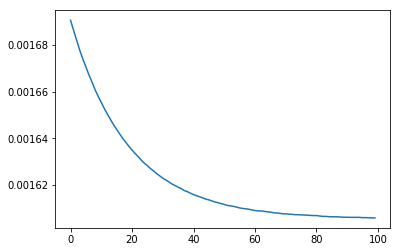

In [74]:
results = net.train(X, y, 0.05)
print("Train acc: %f -> %f\nTrain loss: %f -> %f" % (results['train_acc_history'][0], results['train_acc_history'][-1]
                                                , results['loss_history'][0],results['loss_history'][-1]))
loss_result = np.zeros(0)

for i, x in enumerate(results['loss_history']):
    loss_result = np.append(loss_result, x.numpy()[0])

plt.plot(loss_result)
